# Background Removal with PCA
Demonstration of background removal on videos and images using PCA. Many parts adapted from Professor Rachel Thomas' notebook on [background removal with robust PCA](https://github.com/fastai/numerical-linear-algebra/blob/master/nbs/3.%20Background%20Removal%20with%20Robust%20PCA.ipynb) and Jean Kossaifi's notebook on [robust tensor PCA with Tensorly](http://jeankossaifi.com/blog/rpca.html).

## Imports

In [1]:
import moviepy.editor as mpe
from glob import glob
import sys, os
import numpy as np
import scipy
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.decomposition import PCA
from tensorly.decomposition import robust_pca

%matplotlib inline

ModuleNotFoundError: No module named 'moviepy'

## Background Removal for Videos

Here I perform background removal on a video of cars on a highway using sklearn's PCA and [Tensorly's robust PCA](http://tensorly.org/stable/modules/generated/tensorly.decomposition.robust_pca.html) functions. 

### Helper Methods

In [41]:
def create_data_matrix_from_video(clip, k=5, scale=50):
    return np.vstack([scipy.misc.imresize(rgb2gray(clip.get_frame(i/float(k))).astype(int), 
                      scale).flatten() for i in range(k * int(clip.duration))]).T

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def plots(ims, dims, figsize=(15,20), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        plt.imshow(np.reshape(ims[i], dims), cmap="gray")

In [42]:
def plt_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            pixels = mat[:,i]
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f

In [43]:
def saltpepper(image, p):
    sp_image = np.copy(image)
    
    n = int(np.ceil(len(image) * p / 2))
    
    for i in range(n):
        sp_image[np.random.randint(0, len(image) - 1)] = 0
        sp_image[np.random.randint(0, len(image) - 1)] = 255
    
    return sp_image

In [44]:
# Credits to Jean Kossaifi for function
def visualize_rpca(X, low_rank_part, sparse_part, n_images=10):
    """A little helper function to visualise the result of tensor RPCA
    """
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    indices = indices[:n_images]

    fig = plt.figure(figsize=(12, 2*n_images))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    # plot the digits: each image is 8x8 pixels
    for i, e in enumerate(indices):
        cmap = plt.cm.Greys_r

        ax = fig.add_subplot(n_images, 4, 4*i + 1, xticks=[], yticks=[])
        ax.imshow(X[e], cmap=cmap, interpolation='nearest')
        if not i:
            ax.set_title('Original')

        ax = fig.add_subplot(n_images, 4, 4*i + 2, xticks=[], yticks=[])
        ax.imshow(low_rank_part[e], cmap=cmap, interpolation='nearest')
        if not i:
            ax.set_title('Low-rank')

        ax = fig.add_subplot(n_images, 4, 4*i + 3, xticks=[], yticks=[])
        ax.imshow(sparse_part[e], cmap=cmap, interpolation='nearest')
        if not i:
            ax.set_title('Sparse')

#         ax = fig.add_subplot(n_images, 4, 4*i + 4, xticks=[], yticks=[])
#         ax.imshow(low_rank_part[e]+sparse_part[e], cmap=cmap, interpolation='nearest')
#         if not i:
#             ax.set_title('Reconstruction')

### Load Data

Link to videos: http://cvrr.ucsd.edu/aton/shadow/index.html

Here is the video we want to analyze:

In [3]:
vid = mpe.VideoFileClip("data/highwayII_raw.avi")
vid.subclip(0,50).ipython_display(width=400)

100%|█████████▉| 750/751 [00:01<00:00, 602.68it/s]


In [4]:
scale = 25   # Adjust scale to change resolution of image
dims = (int(240 * (scale/100)), int(320 * (scale/100)))

M = create_data_matrix_from_video(vid, 100, scale)
# M = np.load("high_res_surveillance_matrix.npy")

dims, M.shape

(60, 80) (4800, 3300)


If we take a look at the matrix M created from the AVI, we can see that that the matrix has a very distinct structure. Each frame of the video has been flattened into a single column and successive columns represent advancing in time. With this, we can interpret the horizontal striations as an indication that much of the video remains constant throughout its entire duration. The 'waviness' can be interpreted as the transient portion of the video (the cars).

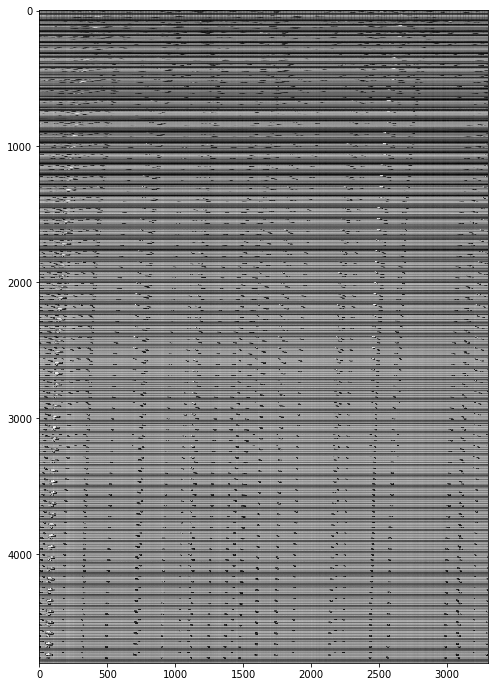

In [5]:
plt.figure(figsize=(12,12))
plt.imshow(M, cmap='gray');

### PCA

The idea behind PCA is to find the best k-rank estimate of a matrix A that we can call L. Mathematically, this means that we are trying to minimize the following function:

$$ \lvert \lvert M-L \lvert \lvert, \text{where } rank(L) = k $$

If we specify the number of components (rank) to be 1, we get a matrix with one column.

In [6]:
n_components = 1
pca = PCA(n_components=n_components)

pca.fit(M)
M_low = pca.transform(M)
M_low.shape

(4800, 1)

By reshaping the column into the dimensions of the original video, we get the background, in this case, an empty highway.

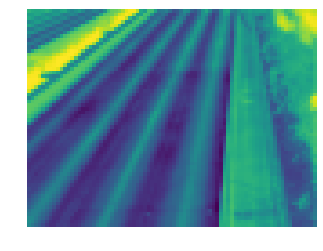

In [7]:
plt.imshow(np.reshape(M_low, dims))
plt.axis('off');

### Robust PCA

Whereas PCA finds a low rank approximation of a matrix $M$, robust PCA decomposes $M$ into the low rank background matrix ($L$) and the sparse foreground matrix ($S$). For this application, robust PCA actively searches for the background ($L$) and the foreground ($S$).

Before passing the data to the *robust_pca* function, I have reshaped it into (n_images, height, width):

In [20]:
X = M.T.reshape((-1, dims[0], dims[1]))
X.shape, X[0].shape

((3300, 60, 80), (60, 80))

Now it's a lot easier to index.

In [25]:
plt.imshow(X[0]);

One last pre-processing step is to normalize the pixel values and convert them into float64.

In [23]:
X = X.astype(np.float64)
X -= X.mean()

Now, we can use Tensorly's robust_pca function to decompose $X$ into a low rank tensor $L$ and a sparse tensor $S$.

In [27]:
L, S = robust_pca(X)

KeyboardInterrupt: 

Here are the results:

In [ ]:
visualize_rpca(sp_image_reshaped, D, M, n_images=4)

## Face Recognition

Another application of robust PCA is face recognition. The same ability of robust PCA to decompose a video into the foreground and background can be used to identify an person's face in a noisy or corrupted photo. The foreground in this case can be thought of as the noise and the background the person's face.

### Load Data

Let's try using the [AT&T face dataset](https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html) we used for 'Facial Decomposition with NMF and SVD'.

In [87]:
path = os.getcwd()
ims = np.array([plt.imread(f).flatten() for f in glob(path + '/data/att_faces/**/*.pgm', recursive=True)]).T
ims.shape

(10304, 400)

Here are a few images from the dataset.

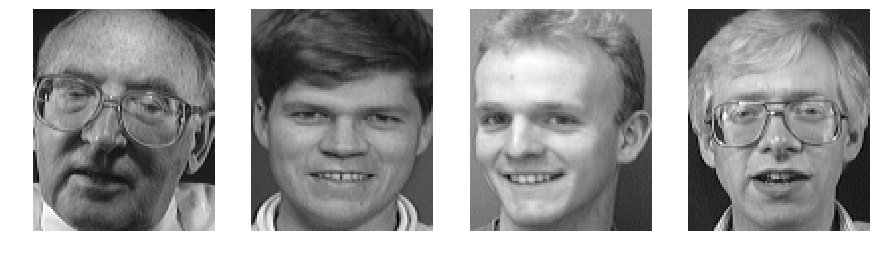

In [88]:
dims = [112,92] # image dims
plots(ims[:,0:40:10].T, dims)

### Speckle Removal

Let's introduce some random to the photos in the form of speckles. Here are the four photos from above corrupted at various severities.

In [50]:
p = [0.05, 0.25, 0.5, 0.75]

fig = plt.figure(figsize=(10, 2))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

sp_image = np.empty([dims[0] * dims[1], len(p)])
for i in range(len(p)):
    sp_image[:,i] = np.array(saltpepper(ims[:,i * 10], p[i]))

plots(sp_image.T,dims)

<Figure size 720x144 with 0 Axes>

In [51]:
sp_image.shape

(10304, 4)

Reshape the array before passing to the RPCA function.

In [52]:
sp_image_reshaped = np.reshape(sp_image.T, (-1, dims[0], dims[1]))
sp_image_reshaped.shape

(4, 112, 92)

Now we can use Tensorly's robust PCA to separate the noise and the face.

In [53]:
L, S = robust_pca(sp_image_reshaped, reg_E=0.13, learning_rate=1.2, 
                  n_iter_max=20)

The RPCA algorithm is able to separate the individuals' faces from the speckles very well.

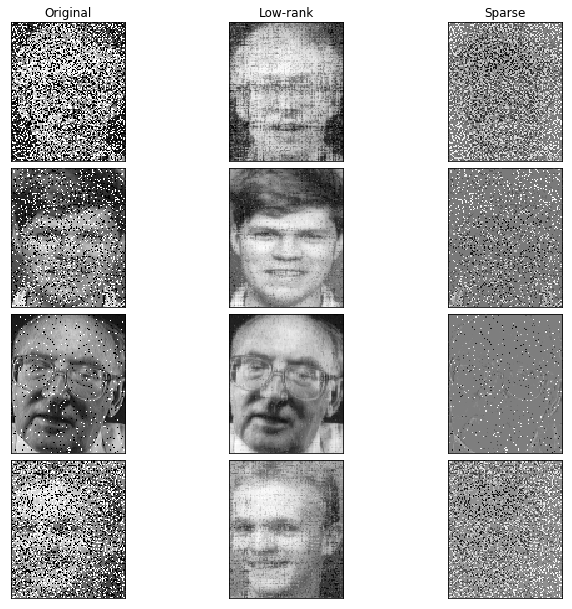

In [55]:
visualize_rpca(sp_image_reshaped, L, S, n_images=4)